<a href="https://colab.research.google.com/github/Steve-YJ/Colab_Exercise/blob/master/Again_Training_Exp03_Train_AgainVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# README.MD
* Try Again, Fin...Fin...Fin...!!
* back to Original Kingma's VAE to Malimg
    * optimizer learning rate: 1e-3
    * optimizer params: sum to mean
* Add 
    * plot train, test loss
        * save it every Epochs
    * plot latent vector per 10 Epoch
        * save it every 10 Epoch
    * save model's state dict per 10 Epoch
    * save latent vector per 10 Epoch

* ✅ Check Point
    * Just try it again...!
    * last exp result is not so good.
        * I think it is the limitation of linear combination...
    * Train again to get some results
    
## Reference
* Reference repository: https://github.com/pytorch/examples/tree/master/vae

* Reference for Visualization: https://github.com/tayden/VAE-Latent-Space-Explorer/blob/master/scripts/VAE.ipynb


In [1]:
! nvidia-smi

Fri Jul  3 23:57:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# drive mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [4]:
%cd drive/My\ Drive/InfoSec_Summer_part2
! pwd

/content/drive/My Drive/InfoSec_Summer_part2
/content/drive/My Drive/InfoSec_Summer_part2


## 01. Import Library

In [5]:
from PIL import Image
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
 
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
import seaborn as sns

# save single numpy array
# https://numpy.org/doc/stable/reference/generated/numpy.save.html#numpy.save
from tempfile import TemporaryFile
from sklearn.manifold import TSNE

import torch
import torch.utils.data

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 02. Data Preprocessing
* Load dataset
* preprocess it
    * transforms
    * make custom dataset
    * train_test split: <code>torch.utils.data.random_split</code>
    * train_test_loader

### Work Flow
* transforms module 사용해서 image data compose 하기
    * size 조정, normalize, tensor 변환
* ImageFolder를 이용해 dataload
* dataset split: train dataset, test dataset
* DataLoader로 batch단위 dataset 불러오기

In [6]:
transforms = transforms.Compose([
                                transforms.Resize((224, 224)),                # Change size of Image to (224, 224)
                                transforms.Grayscale(num_output_channels=1),  # Makes it 1-dimension channel
                                transforms.ToTensor(),                        # Convert a PIL Image or numpy.ndarray to tensor.
                                                                              # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8
                                                                              # In the other cases, tensors are returned without scaling.
                                # transforms.Normalize(mean=[0.5], std=[0.5]),
                                
                                ])

# make custom dataset
trainset = torchvision.datasets.ImageFolder(root='../InformationSecurity_Summer/malimg',
                                            transform=transforms)  # make custom dataset

In [7]:
trainset

Dataset ImageFolder
    Number of datapoints: 9339
    Root location: ../InformationSecurity_Summer/malimg
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [8]:
# classes = trainset.classes
classes = trainset.classes
classes

['Adialer.C',
 'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [9]:
full_dataset = trainset
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
print(train_size, test_size)

train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

7471 1868


In [10]:
'''
for idx, (data, _) in enumerate(test_dataset):
    if idx == 5: 
        break
    else:
        print(data, _)
'''

'\nfor idx, (data, _) in enumerate(test_dataset):\n    if idx == 5: \n        break\n    else:\n        print(data, _)\n'

In [11]:
train_loader = DataLoader(train_dataset,
                         batch_size=16,
                         shuffle=True,
                         pin_memory=True) 
test_loader = DataLoader(test_dataset,
                        batch_size=16,
                        shuffle=True,
                        pin_memory=True)  # Instead, we recommend using automatic memory pinning (i.e., setting pin_memory=True)
                                          #  which enables fast data transfer to CUDA-enabled GPUs

# First, insert all test dataset
# test_loader_10: testloader for latent vector visualization
test_loader_10 = DataLoader(test_dataset,
                        batch_size=1868,
                        shuffle=True,
                        pin_memory=True)

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    np_img = img.numpy()

    plt.imshow(np.transpose(np_img, (1, 2, 0)))  # Convert (C, W, H) to (W, H, C)

    print(np_img.shape)  # np_img shape
    print((np.transpose(np_img, (1, 2, 0))).shape)  # transposed shape 

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(labels)

tensor([ 3,  2,  1, 22,  0, 24,  2,  2, 21, 24, 24,  2,  2, 24,  2, 13])


torch.Size([16, 1, 224, 224])
(3, 906, 906)
(906, 906, 3)
torch.Size([16, 1, 224, 224])
torch.Size([3, 454, 1810])
Allaple.L Allaple.A Agent.FYI VB.AT Adialer.C Yuner.A Allaple.A Allaple.A Swizzor.gen!I Yuner.A Yuner.A Allaple.A Allaple.A Yuner.A Allaple.A Lolyda.AA2 


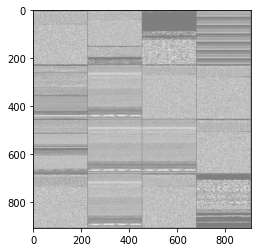

In [14]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

## 03. Define VAE Class
* Initialize
    * (224, 224) input 이미지를 통해 1차원 100개의 latent vector를 생성하는 Encoder네트워크 정의
    * 100개의 latent vector로부터 X_hat을 복원하는 Decoder Network 정의
* encode
* reparameterize
* decode
* forward

In [15]:
device = torch.device("cuda")  # device = torch.device("cuda")

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(224*224, 1000)
        self.fc21 = nn.Linear(1000, 100)
        self.fc22 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 1000)
        self.fc4 = nn.Linear(1000, 224*224)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))
# loss값이 안줄면 sigmoid함수를 제거하고 BCE with Logits Loss를 사용해볼까?
# https://nuguziii.github.io/dev/dev-002/

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 224*224))
        z = self.reparameterize(mu, logvar)  # z's shape => (batch_size, 100)
        return self.decode(z), mu, logvar, z

In [16]:
model = VAE().to(device)
print(model)

VAE(
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc21): Linear(in_features=1000, out_features=100, bias=True)
  (fc22): Linear(in_features=1000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=50176, bias=True)
)


In [17]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [18]:
get_n_params(model)  

100704376

*Note*<br>
1-milion params.... it is so huge...

In [19]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [20]:
# track and save train, test loss through Dictionary
# 
Epoch_Loss = {'train_epoch':[],
              'train_loss':[],
              'test_epoch':[],
              'test_loss':[]}

# Save & Loading Model for Inference
# Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

# PATH = '/Again_original_Exp01_200-Epoch.pth'

PATH = 'Epochs.pth'
# latent_vector = np.zeros((16, 100))
color_palette = np.zeros((1868))


In [23]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 224*224), reduction='sum')  # (input, target, ... reduction)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def train(epoch):
    model.train()
    train_loss = 0
    # latent_vector = np.zeros(())
    # latent_label = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, z= model(data)
    
       
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    Epoch_Loss['train_epoch'].append(epoch)
    Epoch_Loss['train_loss'].append(train_loss / len(train_loader.dataset))
   
def test(epoch):
    # 10 Epoch 단위로 작업
    # model.state_dict() 저장 및 latent_vector 저장
    # plot latent vector
    if epoch % 10 == 0:  # Epoch이 10의 배수일때
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 224, 224)[:n]])
                    save_image(comparison.cpu(),
                            './Exp03_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        Epoch_Loss['test_epoch'].append(epoch)
        Epoch_Loss['test_loss'].append(test_loss)

        # save model.state_dict() per 10 Epochs
        torch.save(model.state_dict(), ('./Exp03_results/model_save_' + str(epoch) + PATH))  # Epoch 단위 parameter 저장

        # load_whole test_data 
        for i, (data, _) in enumerate(test_loader_10):  # load_whole test_data
            data = data.to(device)
            recon_batch, mu, logvar, z = model(data)
        # save latent_vector per 10 Epochs
            latent_vector = z.detach().cpu().clone().numpy()  # change tensor type data to cpu().numpy()
                                                              # latent_vector_size: (num_of_data, 100)
            color_palette = _.detach().cpu().clone().numpy()
            with open(('./Exp03_results/'+str(epoch)+'Epoch_z_vector.npy'), 'wb') as f:
                np.save(f, latent_vector)  # but latent vector size is (16, 100).... just 16...
                                           # 10 Epoch 단위로 latent vector를 저장한다
                                           # 이 떄, latent vector의 size는 test_dataset의 크기가 되어야 한다
                                           # 결과값이 좋은 vector는 좋은 feature로 사용할 수 있다.
        # plot latent vector Every 10 Epochs
        # t-SNE for Dimensionality reduction
        Z_embedded = TSNE(n_components=2).fit_transform(latent_vector)
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))  # setup the plot

        x = Z_embedded[:, 0]
        y = Z_embedded[:, 1]
        label = color_palette
        # label[10:12] = 0  # make sure there are some 0 values to show up as grey
        print("=="*20, "params", "=="*20)
        print("Z_embedded.shape:", Z_embedded.shape)
        print("label.shape:", label.shape)
        # tsne_data = np.vstack((Z_embedded, label))
        tsne_data = np.c_[Z_embedded, label]
        tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
        sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
        plt.savefig('./Exp03_results/plot_latent_vector/' + str(epoch) + '_t_SNE.png', dpi=300)
        plt.show()

    elif epoch % 10 !=0:
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (data, _) in enumerate(test_loader):
                data = data.to(device)
                recon_batch, mu, logvar, z = model(data)
                # z vector는 torch type
                # latent_vector = z.detach().cpu().clone().numpy()
                test_loss += loss_function(recon_batch, data, mu, logvar).item()
                if i == 0:
                    n = min(data.size(0), 8)
                    comparison = torch.cat([data[:n],
                                        recon_batch.view(16, 1, 224, 224)[:n]])
                    save_image(comparison.cpu(),
                            './Exp03_results/recon_sampling/reconstruction_' + str(epoch) + '.png', nrow=n)
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        Epoch_Loss['test_epoch'].append(epoch)
        Epoch_Loss['test_loss'].append(test_loss)

*Notice*<br>
Train Again!<br>
Change BCE loss param_reduction to 'sum'

1
Train Epoch: 1 [0/7471 (0%)]	Loss: 35140.246094
Train Epoch: 1 [160/7471 (2%)]	Loss: 38273.296875
Train Epoch: 1 [320/7471 (4%)]	Loss: 36783.183594
Train Epoch: 1 [480/7471 (6%)]	Loss: 36845.992188
Train Epoch: 1 [640/7471 (9%)]	Loss: 36636.718750
Train Epoch: 1 [800/7471 (11%)]	Loss: 36777.074219
Train Epoch: 1 [960/7471 (13%)]	Loss: 36449.121094
Train Epoch: 1 [1120/7471 (15%)]	Loss: 36375.273438
Train Epoch: 1 [1280/7471 (17%)]	Loss: 36049.078125
Train Epoch: 1 [1440/7471 (19%)]	Loss: 36857.183594
Train Epoch: 1 [1600/7471 (21%)]	Loss: 36374.679688
Train Epoch: 1 [1760/7471 (24%)]	Loss: 35577.484375
Train Epoch: 1 [1920/7471 (26%)]	Loss: 36358.128906
Train Epoch: 1 [2080/7471 (28%)]	Loss: 35746.789062
Train Epoch: 1 [2240/7471 (30%)]	Loss: 37016.582031
Train Epoch: 1 [2400/7471 (32%)]	Loss: 35848.347656
Train Epoch: 1 [2560/7471 (34%)]	Loss: 35967.316406
Train Epoch: 1 [2720/7471 (36%)]	Loss: 35561.207031
Train Epoch: 1 [2880/7471 (39%)]	Loss: 35776.753906
Train Epoch: 1 [3040/747

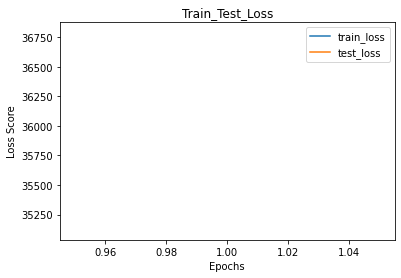

2
Train Epoch: 2 [0/7471 (0%)]	Loss: 34521.824219
Train Epoch: 2 [160/7471 (2%)]	Loss: 36384.562500
Train Epoch: 2 [320/7471 (4%)]	Loss: 35385.445312
Train Epoch: 2 [480/7471 (6%)]	Loss: 34731.171875
Train Epoch: 2 [640/7471 (9%)]	Loss: 34787.023438
Train Epoch: 2 [800/7471 (11%)]	Loss: 35002.589844
Train Epoch: 2 [960/7471 (13%)]	Loss: 34331.250000
Train Epoch: 2 [1120/7471 (15%)]	Loss: 33895.628906
Train Epoch: 2 [1280/7471 (17%)]	Loss: 34149.503906
Train Epoch: 2 [1440/7471 (19%)]	Loss: 33664.300781
Train Epoch: 2 [1600/7471 (21%)]	Loss: 35727.570312
Train Epoch: 2 [1760/7471 (24%)]	Loss: 35463.210938
Train Epoch: 2 [1920/7471 (26%)]	Loss: 34642.468750
Train Epoch: 2 [2080/7471 (28%)]	Loss: 34420.578125
Train Epoch: 2 [2240/7471 (30%)]	Loss: 33300.285156
Train Epoch: 2 [2400/7471 (32%)]	Loss: 35646.289062
Train Epoch: 2 [2560/7471 (34%)]	Loss: 33879.582031
Train Epoch: 2 [2720/7471 (36%)]	Loss: 34363.234375
Train Epoch: 2 [2880/7471 (39%)]	Loss: 33821.882812
Train Epoch: 2 [3040/747

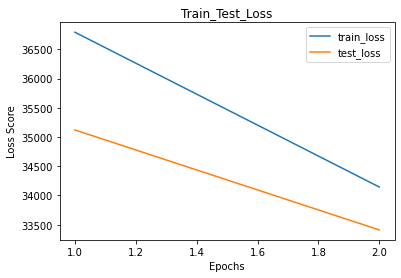

3
Train Epoch: 3 [0/7471 (0%)]	Loss: 33869.585938
Train Epoch: 3 [160/7471 (2%)]	Loss: 33569.000000
Train Epoch: 3 [320/7471 (4%)]	Loss: 34114.269531
Train Epoch: 3 [480/7471 (6%)]	Loss: 33870.953125
Train Epoch: 3 [640/7471 (9%)]	Loss: 33044.367188
Train Epoch: 3 [800/7471 (11%)]	Loss: 34562.218750
Train Epoch: 3 [960/7471 (13%)]	Loss: 33713.160156
Train Epoch: 3 [1120/7471 (15%)]	Loss: 32897.953125
Train Epoch: 3 [1280/7471 (17%)]	Loss: 33521.066406
Train Epoch: 3 [1440/7471 (19%)]	Loss: 32401.507812
Train Epoch: 3 [1600/7471 (21%)]	Loss: 34421.652344
Train Epoch: 3 [1760/7471 (24%)]	Loss: 33023.300781
Train Epoch: 3 [1920/7471 (26%)]	Loss: 32762.070312
Train Epoch: 3 [2080/7471 (28%)]	Loss: 32795.542969
Train Epoch: 3 [2240/7471 (30%)]	Loss: 33708.406250
Train Epoch: 3 [2400/7471 (32%)]	Loss: 33348.449219
Train Epoch: 3 [2560/7471 (34%)]	Loss: 31871.841797
Train Epoch: 3 [2720/7471 (36%)]	Loss: 33684.996094
Train Epoch: 3 [2880/7471 (39%)]	Loss: 33044.238281
Train Epoch: 3 [3040/747

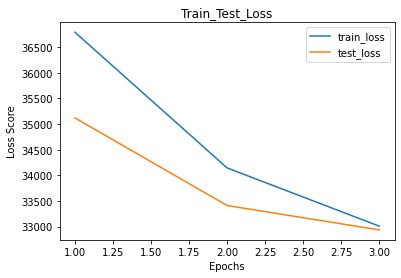

4
Train Epoch: 4 [0/7471 (0%)]	Loss: 31991.535156
Train Epoch: 4 [160/7471 (2%)]	Loss: 32153.265625
Train Epoch: 4 [320/7471 (4%)]	Loss: 31869.199219
Train Epoch: 4 [480/7471 (6%)]	Loss: 33245.167969
Train Epoch: 4 [640/7471 (9%)]	Loss: 33095.660156
Train Epoch: 4 [800/7471 (11%)]	Loss: 33498.500000
Train Epoch: 4 [960/7471 (13%)]	Loss: 33733.441406
Train Epoch: 4 [1120/7471 (15%)]	Loss: 32763.166016
Train Epoch: 4 [1280/7471 (17%)]	Loss: 31160.123047
Train Epoch: 4 [1440/7471 (19%)]	Loss: 30508.443359
Train Epoch: 4 [1600/7471 (21%)]	Loss: 33241.355469
Train Epoch: 4 [1760/7471 (24%)]	Loss: 33472.847656
Train Epoch: 4 [1920/7471 (26%)]	Loss: 33135.460938
Train Epoch: 4 [2080/7471 (28%)]	Loss: 33172.742188
Train Epoch: 4 [2240/7471 (30%)]	Loss: 32916.843750
Train Epoch: 4 [2400/7471 (32%)]	Loss: 33257.269531
Train Epoch: 4 [2560/7471 (34%)]	Loss: 32635.447266
Train Epoch: 4 [2720/7471 (36%)]	Loss: 33883.660156
Train Epoch: 4 [2880/7471 (39%)]	Loss: 32014.425781
Train Epoch: 4 [3040/747

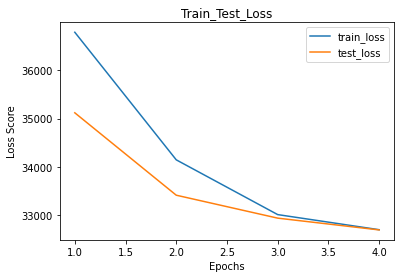

5
Train Epoch: 5 [0/7471 (0%)]	Loss: 31985.976562
Train Epoch: 5 [160/7471 (2%)]	Loss: 31874.406250
Train Epoch: 5 [320/7471 (4%)]	Loss: 31516.179688
Train Epoch: 5 [480/7471 (6%)]	Loss: 31934.365234
Train Epoch: 5 [640/7471 (9%)]	Loss: 33815.941406
Train Epoch: 5 [800/7471 (11%)]	Loss: 32139.156250
Train Epoch: 5 [960/7471 (13%)]	Loss: 33943.289062
Train Epoch: 5 [1120/7471 (15%)]	Loss: 33791.640625
Train Epoch: 5 [1280/7471 (17%)]	Loss: 31858.335938
Train Epoch: 5 [1440/7471 (19%)]	Loss: 32290.117188
Train Epoch: 5 [1600/7471 (21%)]	Loss: 31440.882812
Train Epoch: 5 [1760/7471 (24%)]	Loss: 33020.238281
Train Epoch: 5 [1920/7471 (26%)]	Loss: 32139.591797
Train Epoch: 5 [2080/7471 (28%)]	Loss: 32664.830078
Train Epoch: 5 [2240/7471 (30%)]	Loss: 32270.943359
Train Epoch: 5 [2400/7471 (32%)]	Loss: 32309.806641
Train Epoch: 5 [2560/7471 (34%)]	Loss: 32799.507812
Train Epoch: 5 [2720/7471 (36%)]	Loss: 31425.792969
Train Epoch: 5 [2880/7471 (39%)]	Loss: 32964.574219
Train Epoch: 5 [3040/747

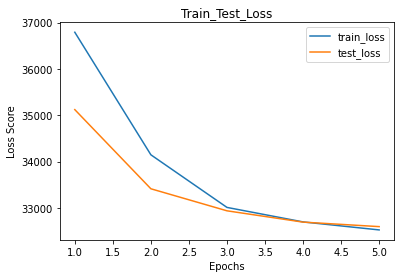

6
Train Epoch: 6 [0/7471 (0%)]	Loss: 33904.046875
Train Epoch: 6 [160/7471 (2%)]	Loss: 32565.423828
Train Epoch: 6 [320/7471 (4%)]	Loss: 32941.585938
Train Epoch: 6 [480/7471 (6%)]	Loss: 31501.011719
Train Epoch: 6 [640/7471 (9%)]	Loss: 30004.195312
Train Epoch: 6 [800/7471 (11%)]	Loss: 33031.304688
Train Epoch: 6 [960/7471 (13%)]	Loss: 32063.048828
Train Epoch: 6 [1120/7471 (15%)]	Loss: 33800.359375
Train Epoch: 6 [1280/7471 (17%)]	Loss: 32258.003906
Train Epoch: 6 [1440/7471 (19%)]	Loss: 32986.664062
Train Epoch: 6 [1600/7471 (21%)]	Loss: 32724.013672
Train Epoch: 6 [1760/7471 (24%)]	Loss: 32463.882812
Train Epoch: 6 [1920/7471 (26%)]	Loss: 32765.523438
Train Epoch: 6 [2080/7471 (28%)]	Loss: 32886.093750
Train Epoch: 6 [2240/7471 (30%)]	Loss: 33579.398438
Train Epoch: 6 [2400/7471 (32%)]	Loss: 33189.238281
Train Epoch: 6 [2560/7471 (34%)]	Loss: 32386.759766
Train Epoch: 6 [2720/7471 (36%)]	Loss: 32660.880859
Train Epoch: 6 [2880/7471 (39%)]	Loss: 32717.994141
Train Epoch: 6 [3040/747

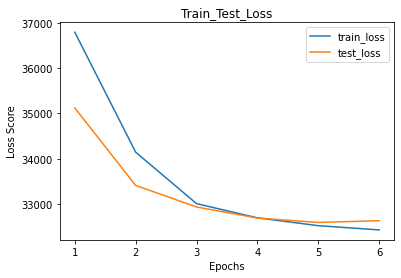

7
Train Epoch: 7 [0/7471 (0%)]	Loss: 33260.207031
Train Epoch: 7 [160/7471 (2%)]	Loss: 32777.140625
Train Epoch: 7 [320/7471 (4%)]	Loss: 33516.394531
Train Epoch: 7 [480/7471 (6%)]	Loss: 31512.960938
Train Epoch: 7 [640/7471 (9%)]	Loss: 31773.150391
Train Epoch: 7 [800/7471 (11%)]	Loss: 33415.230469
Train Epoch: 7 [960/7471 (13%)]	Loss: 32429.724609
Train Epoch: 7 [1120/7471 (15%)]	Loss: 31925.857422
Train Epoch: 7 [1280/7471 (17%)]	Loss: 32164.255859
Train Epoch: 7 [1440/7471 (19%)]	Loss: 32544.242188
Train Epoch: 7 [1600/7471 (21%)]	Loss: 33049.351562
Train Epoch: 7 [1760/7471 (24%)]	Loss: 33662.582031
Train Epoch: 7 [1920/7471 (26%)]	Loss: 32322.193359
Train Epoch: 7 [2080/7471 (28%)]	Loss: 32004.492188
Train Epoch: 7 [2240/7471 (30%)]	Loss: 32425.525391
Train Epoch: 7 [2400/7471 (32%)]	Loss: 32330.388672
Train Epoch: 7 [2560/7471 (34%)]	Loss: 32403.281250
Train Epoch: 7 [2720/7471 (36%)]	Loss: 31876.939453
Train Epoch: 7 [2880/7471 (39%)]	Loss: 32822.394531
Train Epoch: 7 [3040/747

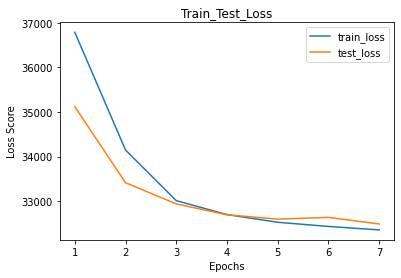

8
Train Epoch: 8 [0/7471 (0%)]	Loss: 32596.755859
Train Epoch: 8 [160/7471 (2%)]	Loss: 31100.191406
Train Epoch: 8 [320/7471 (4%)]	Loss: 32345.125000
Train Epoch: 8 [480/7471 (6%)]	Loss: 33338.097656
Train Epoch: 8 [640/7471 (9%)]	Loss: 30424.146484
Train Epoch: 8 [800/7471 (11%)]	Loss: 33733.343750
Train Epoch: 8 [960/7471 (13%)]	Loss: 31339.552734
Train Epoch: 8 [1120/7471 (15%)]	Loss: 30793.281250
Train Epoch: 8 [1280/7471 (17%)]	Loss: 32569.519531
Train Epoch: 8 [1440/7471 (19%)]	Loss: 31430.007812
Train Epoch: 8 [1600/7471 (21%)]	Loss: 31960.882812
Train Epoch: 8 [1760/7471 (24%)]	Loss: 33747.402344
Train Epoch: 8 [1920/7471 (26%)]	Loss: 33902.187500
Train Epoch: 8 [2080/7471 (28%)]	Loss: 33030.351562
Train Epoch: 8 [2240/7471 (30%)]	Loss: 32428.910156
Train Epoch: 8 [2400/7471 (32%)]	Loss: 33090.007812
Train Epoch: 8 [2560/7471 (34%)]	Loss: 32952.324219
Train Epoch: 8 [2720/7471 (36%)]	Loss: 31094.085938
Train Epoch: 8 [2880/7471 (39%)]	Loss: 30653.671875
Train Epoch: 8 [3040/747

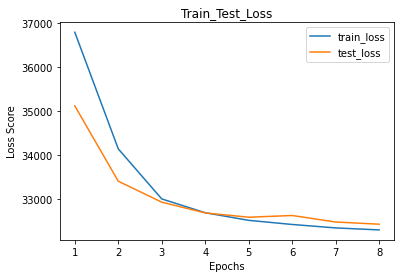

9
Train Epoch: 9 [0/7471 (0%)]	Loss: 33107.144531
Train Epoch: 9 [160/7471 (2%)]	Loss: 32223.275391
Train Epoch: 9 [320/7471 (4%)]	Loss: 32088.744141
Train Epoch: 9 [480/7471 (6%)]	Loss: 31486.945312
Train Epoch: 9 [640/7471 (9%)]	Loss: 33367.753906
Train Epoch: 9 [800/7471 (11%)]	Loss: 32698.970703
Train Epoch: 9 [960/7471 (13%)]	Loss: 33523.984375
Train Epoch: 9 [1120/7471 (15%)]	Loss: 32345.857422
Train Epoch: 9 [1280/7471 (17%)]	Loss: 32240.095703
Train Epoch: 9 [1440/7471 (19%)]	Loss: 31590.400391
Train Epoch: 9 [1600/7471 (21%)]	Loss: 31247.730469
Train Epoch: 9 [1760/7471 (24%)]	Loss: 30844.404297
Train Epoch: 9 [1920/7471 (26%)]	Loss: 30515.279297
Train Epoch: 9 [2080/7471 (28%)]	Loss: 33656.710938
Train Epoch: 9 [2240/7471 (30%)]	Loss: 32149.611328
Train Epoch: 9 [2400/7471 (32%)]	Loss: 31658.818359
Train Epoch: 9 [2560/7471 (34%)]	Loss: 33232.250000
Train Epoch: 9 [2720/7471 (36%)]	Loss: 31736.667969
Train Epoch: 9 [2880/7471 (39%)]	Loss: 32899.835938
Train Epoch: 9 [3040/747

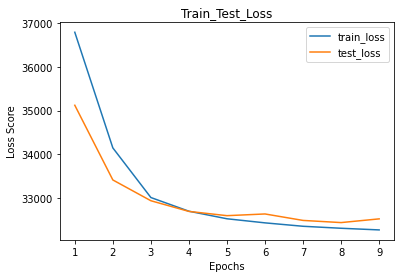

10
Train Epoch: 10 [0/7471 (0%)]	Loss: 33096.546875
Train Epoch: 10 [160/7471 (2%)]	Loss: 32491.964844
Train Epoch: 10 [320/7471 (4%)]	Loss: 32992.015625
Train Epoch: 10 [480/7471 (6%)]	Loss: 32681.306641
Train Epoch: 10 [640/7471 (9%)]	Loss: 32697.175781
Train Epoch: 10 [800/7471 (11%)]	Loss: 31952.103516
Train Epoch: 10 [960/7471 (13%)]	Loss: 31741.248047
Train Epoch: 10 [1120/7471 (15%)]	Loss: 32426.779297
Train Epoch: 10 [1280/7471 (17%)]	Loss: 32428.781250
Train Epoch: 10 [1440/7471 (19%)]	Loss: 33888.144531
Train Epoch: 10 [1600/7471 (21%)]	Loss: 32669.011719
Train Epoch: 10 [1760/7471 (24%)]	Loss: 31372.935547
Train Epoch: 10 [1920/7471 (26%)]	Loss: 32309.568359
Train Epoch: 10 [2080/7471 (28%)]	Loss: 32563.386719
Train Epoch: 10 [2240/7471 (30%)]	Loss: 32873.601562
Train Epoch: 10 [2400/7471 (32%)]	Loss: 32242.068359
Train Epoch: 10 [2560/7471 (34%)]	Loss: 32692.761719
Train Epoch: 10 [2720/7471 (36%)]	Loss: 32771.136719
Train Epoch: 10 [2880/7471 (39%)]	Loss: 32728.708984
Trai

FileNotFoundError: ignored

In [22]:
epochs = 200

for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./Exp03_results/plot_train_test_loss/'+str(epoch)+'_epoch.png', dpi=300)
        plt.show()

        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),
                       './Exp03_results/recon_sampling/sampling_' + str(epoch) + '.png')

1
Train Epoch: 1 [0/7471 (0%)]	Loss: 195037.125000
Train Epoch: 1 [160/7471 (2%)]	Loss: 183753.796875
Train Epoch: 1 [320/7471 (4%)]	Loss: 7823101952.000000
Train Epoch: 1 [480/7471 (6%)]	Loss: 48759.562500
Train Epoch: 1 [640/7471 (9%)]	Loss: 64946.289062
Train Epoch: 1 [800/7471 (11%)]	Loss: 42703.796875
Train Epoch: 1 [960/7471 (13%)]	Loss: 55210.683594
Train Epoch: 1 [1120/7471 (15%)]	Loss: 2597965.500000
Train Epoch: 1 [1280/7471 (17%)]	Loss: 59204.328125
Train Epoch: 1 [1440/7471 (19%)]	Loss: 127670.500000
Train Epoch: 1 [1600/7471 (21%)]	Loss: 177378.421875
Train Epoch: 1 [1760/7471 (24%)]	Loss: 56878.132812
Train Epoch: 1 [1920/7471 (26%)]	Loss: 48748.898438
Train Epoch: 1 [2080/7471 (28%)]	Loss: 42691.445312
Train Epoch: 1 [2240/7471 (30%)]	Loss: 44480.148438
Train Epoch: 1 [2400/7471 (32%)]	Loss: 44223.332031
Train Epoch: 1 [2560/7471 (34%)]	Loss: 42348.656250
Train Epoch: 1 [2720/7471 (36%)]	Loss: 71202.109375
Train Epoch: 1 [2880/7471 (39%)]	Loss: 48269.531250
Train Epoch: 

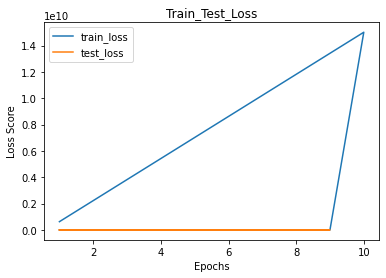

2
Train Epoch: 2 [0/7471 (0%)]	Loss: 41146.398438
Train Epoch: 2 [160/7471 (2%)]	Loss: 43600.269531
Train Epoch: 2 [320/7471 (4%)]	Loss: 42102.542969
Train Epoch: 2 [480/7471 (6%)]	Loss: 43383.722656
Train Epoch: 2 [640/7471 (9%)]	Loss: 42983.820312
Train Epoch: 2 [800/7471 (11%)]	Loss: 41922.445312
Train Epoch: 2 [960/7471 (13%)]	Loss: 41453.843750
Train Epoch: 2 [1120/7471 (15%)]	Loss: 41417.789062
Train Epoch: 2 [1280/7471 (17%)]	Loss: 43419.695312
Train Epoch: 2 [1440/7471 (19%)]	Loss: 41693.710938
Train Epoch: 2 [1600/7471 (21%)]	Loss: 41932.843750
Train Epoch: 2 [1760/7471 (24%)]	Loss: 49722.867188
Train Epoch: 2 [1920/7471 (26%)]	Loss: 45448.109375
Train Epoch: 2 [2080/7471 (28%)]	Loss: 42358.707031
Train Epoch: 2 [2240/7471 (30%)]	Loss: 46899.292969
Train Epoch: 2 [2400/7471 (32%)]	Loss: 45887.191406
Train Epoch: 2 [2560/7471 (34%)]	Loss: 44122.246094
Train Epoch: 2 [2720/7471 (36%)]	Loss: 55102.917969
Train Epoch: 2 [2880/7471 (39%)]	Loss: 49839.222656
Train Epoch: 2 [3040/747

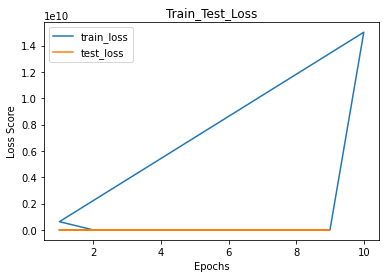

3
Train Epoch: 3 [0/7471 (0%)]	Loss: 43415.843750
Train Epoch: 3 [160/7471 (2%)]	Loss: 43360.269531
Train Epoch: 3 [320/7471 (4%)]	Loss: 42603.625000
Train Epoch: 3 [480/7471 (6%)]	Loss: 43453.230469
Train Epoch: 3 [640/7471 (9%)]	Loss: 57261.445312
Train Epoch: 3 [800/7471 (11%)]	Loss: 49157.164062
Train Epoch: 3 [960/7471 (13%)]	Loss: 43467.570312
Train Epoch: 3 [1120/7471 (15%)]	Loss: 43140.753906
Train Epoch: 3 [1280/7471 (17%)]	Loss: 42304.671875
Train Epoch: 3 [1440/7471 (19%)]	Loss: 41977.890625
Train Epoch: 3 [1600/7471 (21%)]	Loss: 42234.984375
Train Epoch: 3 [1760/7471 (24%)]	Loss: 43388.832031
Train Epoch: 3 [1920/7471 (26%)]	Loss: 42908.976562
Train Epoch: 3 [2080/7471 (28%)]	Loss: 41868.175781
Train Epoch: 3 [2240/7471 (30%)]	Loss: 42368.773438
Train Epoch: 3 [2400/7471 (32%)]	Loss: 42688.175781
Train Epoch: 3 [2560/7471 (34%)]	Loss: 42228.296875
Train Epoch: 3 [2720/7471 (36%)]	Loss: 42986.039062
Train Epoch: 3 [2880/7471 (39%)]	Loss: 43100.218750
Train Epoch: 3 [3040/747

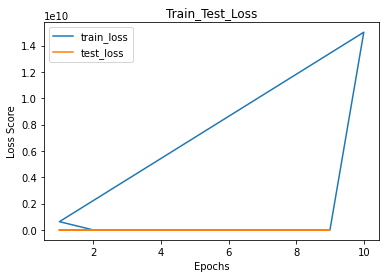

4
Train Epoch: 4 [0/7471 (0%)]	Loss: 43651.394531
Train Epoch: 4 [160/7471 (2%)]	Loss: 44047.074219
Train Epoch: 4 [320/7471 (4%)]	Loss: 41623.820312
Train Epoch: 4 [480/7471 (6%)]	Loss: 42349.109375
Train Epoch: 4 [640/7471 (9%)]	Loss: 42907.980469
Train Epoch: 4 [800/7471 (11%)]	Loss: 42730.796875
Train Epoch: 4 [960/7471 (13%)]	Loss: 42456.203125
Train Epoch: 4 [1120/7471 (15%)]	Loss: 43195.687500
Train Epoch: 4 [1280/7471 (17%)]	Loss: 42738.039062
Train Epoch: 4 [1440/7471 (19%)]	Loss: 42293.824219
Train Epoch: 4 [1600/7471 (21%)]	Loss: 42252.488281
Train Epoch: 4 [1760/7471 (24%)]	Loss: 42517.070312
Train Epoch: 4 [1920/7471 (26%)]	Loss: 42445.148438
Train Epoch: 4 [2080/7471 (28%)]	Loss: 42861.226562
Train Epoch: 4 [2240/7471 (30%)]	Loss: 42558.066406
Train Epoch: 4 [2400/7471 (32%)]	Loss: 41340.332031
Train Epoch: 4 [2560/7471 (34%)]	Loss: 42912.484375
Train Epoch: 4 [2720/7471 (36%)]	Loss: 43586.382812
Train Epoch: 4 [2880/7471 (39%)]	Loss: 42042.316406
Train Epoch: 4 [3040/747

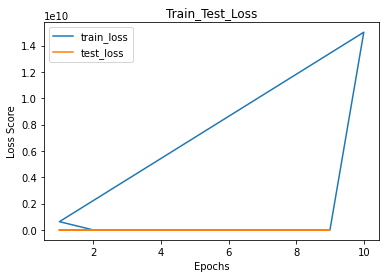

5
Train Epoch: 5 [0/7471 (0%)]	Loss: 41529.550781
Train Epoch: 5 [160/7471 (2%)]	Loss: 40013.957031
Train Epoch: 5 [320/7471 (4%)]	Loss: 43193.367188
Train Epoch: 5 [480/7471 (6%)]	Loss: 42199.078125
Train Epoch: 5 [640/7471 (9%)]	Loss: 40590.640625
Train Epoch: 5 [800/7471 (11%)]	Loss: 43049.664062
Train Epoch: 5 [960/7471 (13%)]	Loss: 41440.113281
Train Epoch: 5 [1120/7471 (15%)]	Loss: 41955.289062
Train Epoch: 5 [1280/7471 (17%)]	Loss: 41871.929688
Train Epoch: 5 [1440/7471 (19%)]	Loss: 42224.234375
Train Epoch: 5 [1600/7471 (21%)]	Loss: 40731.015625
Train Epoch: 5 [1760/7471 (24%)]	Loss: 41154.589844
Train Epoch: 5 [1920/7471 (26%)]	Loss: 41930.339844
Train Epoch: 5 [2080/7471 (28%)]	Loss: 40846.316406
Train Epoch: 5 [2240/7471 (30%)]	Loss: 42467.265625
Train Epoch: 5 [2400/7471 (32%)]	Loss: 40292.546875
Train Epoch: 5 [2560/7471 (34%)]	Loss: 41785.539062
Train Epoch: 5 [2720/7471 (36%)]	Loss: 42241.386719
Train Epoch: 5 [2880/7471 (39%)]	Loss: 41372.558594
Train Epoch: 5 [3040/747

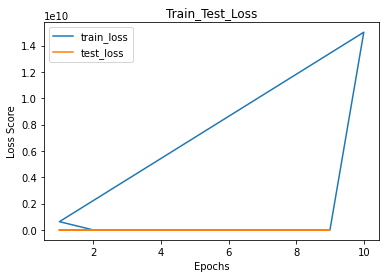

6
Train Epoch: 6 [0/7471 (0%)]	Loss: 54519.417969
Train Epoch: 6 [160/7471 (2%)]	Loss: 48679.562500
Train Epoch: 6 [320/7471 (4%)]	Loss: 42085.968750
Train Epoch: 6 [480/7471 (6%)]	Loss: 41478.585938
Train Epoch: 6 [640/7471 (9%)]	Loss: 40930.238281
Train Epoch: 6 [800/7471 (11%)]	Loss: 41945.851562
Train Epoch: 6 [960/7471 (13%)]	Loss: 40963.503906
Train Epoch: 6 [1120/7471 (15%)]	Loss: 42465.109375
Train Epoch: 6 [1280/7471 (17%)]	Loss: 40294.937500
Train Epoch: 6 [1440/7471 (19%)]	Loss: 41456.328125
Train Epoch: 6 [1600/7471 (21%)]	Loss: 40641.488281
Train Epoch: 6 [1760/7471 (24%)]	Loss: 41636.523438
Train Epoch: 6 [1920/7471 (26%)]	Loss: 40059.953125
Train Epoch: 6 [2080/7471 (28%)]	Loss: 41796.945312
Train Epoch: 6 [2240/7471 (30%)]	Loss: 43091.949219
Train Epoch: 6 [2400/7471 (32%)]	Loss: 44225.867188
Train Epoch: 6 [2560/7471 (34%)]	Loss: 42466.320312
Train Epoch: 6 [2720/7471 (36%)]	Loss: 40885.804688
Train Epoch: 6 [2880/7471 (39%)]	Loss: 41899.492188
Train Epoch: 6 [3040/747

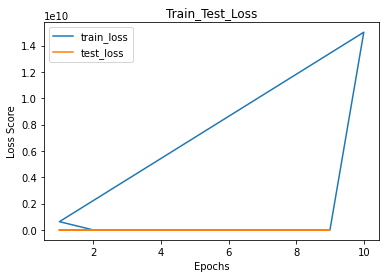

7
Train Epoch: 7 [0/7471 (0%)]	Loss: 42011.628906
Train Epoch: 7 [160/7471 (2%)]	Loss: 41750.281250
Train Epoch: 7 [320/7471 (4%)]	Loss: 42112.828125
Train Epoch: 7 [480/7471 (6%)]	Loss: 41689.679688
Train Epoch: 7 [640/7471 (9%)]	Loss: 39845.570312
Train Epoch: 7 [800/7471 (11%)]	Loss: 40849.964844
Train Epoch: 7 [960/7471 (13%)]	Loss: 42449.304688
Train Epoch: 7 [1120/7471 (15%)]	Loss: 41411.988281
Train Epoch: 7 [1280/7471 (17%)]	Loss: 41262.707031
Train Epoch: 7 [1440/7471 (19%)]	Loss: 42280.851562
Train Epoch: 7 [1600/7471 (21%)]	Loss: 41050.230469
Train Epoch: 7 [1760/7471 (24%)]	Loss: 42419.546875
Train Epoch: 7 [1920/7471 (26%)]	Loss: 40944.554688
Train Epoch: 7 [2080/7471 (28%)]	Loss: 42354.195312
Train Epoch: 7 [2240/7471 (30%)]	Loss: 41179.144531
Train Epoch: 7 [2400/7471 (32%)]	Loss: 42362.421875
Train Epoch: 7 [2560/7471 (34%)]	Loss: 41654.195312
Train Epoch: 7 [2720/7471 (36%)]	Loss: 40859.476562
Train Epoch: 7 [2880/7471 (39%)]	Loss: 40916.289062
Train Epoch: 7 [3040/747

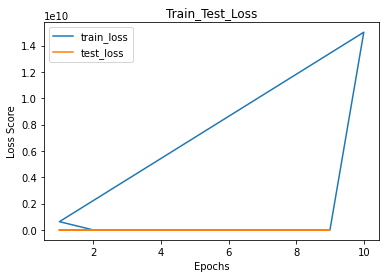

8
Train Epoch: 8 [0/7471 (0%)]	Loss: 47803.945312
Train Epoch: 8 [160/7471 (2%)]	Loss: 42314.539062
Train Epoch: 8 [320/7471 (4%)]	Loss: 40661.042969
Train Epoch: 8 [480/7471 (6%)]	Loss: 40032.363281
Train Epoch: 8 [640/7471 (9%)]	Loss: 41399.144531
Train Epoch: 8 [800/7471 (11%)]	Loss: 40159.718750
Train Epoch: 8 [960/7471 (13%)]	Loss: 42445.707031
Train Epoch: 8 [1120/7471 (15%)]	Loss: 42906.125000
Train Epoch: 8 [1280/7471 (17%)]	Loss: 40882.078125
Train Epoch: 8 [1440/7471 (19%)]	Loss: 41363.156250
Train Epoch: 8 [1600/7471 (21%)]	Loss: 41367.273438
Train Epoch: 8 [1760/7471 (24%)]	Loss: 40747.027344
Train Epoch: 8 [1920/7471 (26%)]	Loss: 41438.296875
Train Epoch: 8 [2080/7471 (28%)]	Loss: 41937.929688
Train Epoch: 8 [2240/7471 (30%)]	Loss: 39828.390625
Train Epoch: 8 [2400/7471 (32%)]	Loss: 40020.984375
Train Epoch: 8 [2560/7471 (34%)]	Loss: 41188.339844
Train Epoch: 8 [2720/7471 (36%)]	Loss: 39950.019531
Train Epoch: 8 [2880/7471 (39%)]	Loss: 39761.667969
Train Epoch: 8 [3040/747

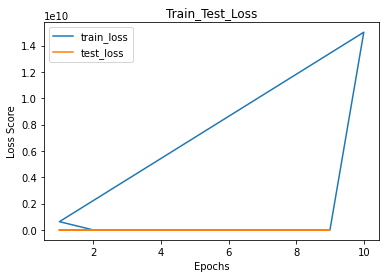

9
Train Epoch: 9 [0/7471 (0%)]	Loss: 40408.039062
Train Epoch: 9 [160/7471 (2%)]	Loss: 41246.203125
Train Epoch: 9 [320/7471 (4%)]	Loss: 40805.968750
Train Epoch: 9 [480/7471 (6%)]	Loss: 39604.261719
Train Epoch: 9 [640/7471 (9%)]	Loss: 41733.199219
Train Epoch: 9 [800/7471 (11%)]	Loss: 41136.886719
Train Epoch: 9 [960/7471 (13%)]	Loss: 41132.296875
Train Epoch: 9 [1120/7471 (15%)]	Loss: 40103.734375
Train Epoch: 9 [1280/7471 (17%)]	Loss: 39998.140625
Train Epoch: 9 [1440/7471 (19%)]	Loss: 49151.632812
Train Epoch: 9 [1600/7471 (21%)]	Loss: 43706.257812
Train Epoch: 9 [1760/7471 (24%)]	Loss: 39133.453125
Train Epoch: 9 [1920/7471 (26%)]	Loss: 39511.781250
Train Epoch: 9 [2080/7471 (28%)]	Loss: 40365.492188
Train Epoch: 9 [2240/7471 (30%)]	Loss: 40833.367188
Train Epoch: 9 [2400/7471 (32%)]	Loss: 42034.718750
Train Epoch: 9 [2560/7471 (34%)]	Loss: 40944.156250
Train Epoch: 9 [2720/7471 (36%)]	Loss: 38862.457031
Train Epoch: 9 [2880/7471 (39%)]	Loss: 41121.421875
Train Epoch: 9 [3040/747

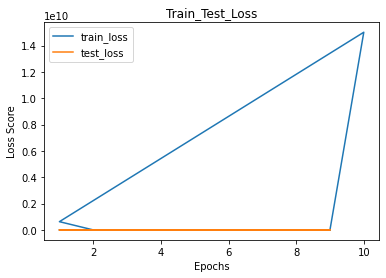

10
Train Epoch: 10 [0/7471 (0%)]	Loss: 42644.417969
Train Epoch: 10 [160/7471 (2%)]	Loss: 40964.578125
Train Epoch: 10 [320/7471 (4%)]	Loss: 45821.757812
Train Epoch: 10 [480/7471 (6%)]	Loss: 44682.679688
Train Epoch: 10 [640/7471 (9%)]	Loss: 41154.136719
Train Epoch: 10 [800/7471 (11%)]	Loss: 39675.859375
Train Epoch: 10 [960/7471 (13%)]	Loss: 41147.746094
Train Epoch: 10 [1120/7471 (15%)]	Loss: 42479.863281
Train Epoch: 10 [1280/7471 (17%)]	Loss: 45393.906250
Train Epoch: 10 [1440/7471 (19%)]	Loss: 40974.093750
Train Epoch: 10 [1600/7471 (21%)]	Loss: 43379.515625
Train Epoch: 10 [1760/7471 (24%)]	Loss: 43529.820312
Train Epoch: 10 [1920/7471 (26%)]	Loss: 40179.339844
Train Epoch: 10 [2080/7471 (28%)]	Loss: 40012.867188
Train Epoch: 10 [2240/7471 (30%)]	Loss: 40318.320312
Train Epoch: 10 [2400/7471 (32%)]	Loss: 39785.214844
Train Epoch: 10 [2560/7471 (34%)]	Loss: 40526.488281
Train Epoch: 10 [2720/7471 (36%)]	Loss: 37425.472656
Train Epoch: 10 [2880/7471 (39%)]	Loss: 39797.875000
Trai

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


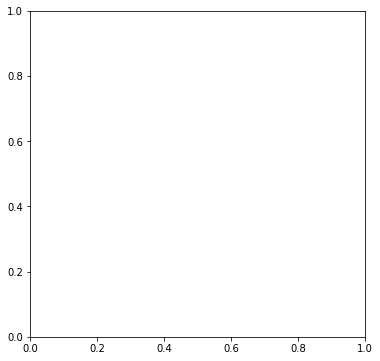

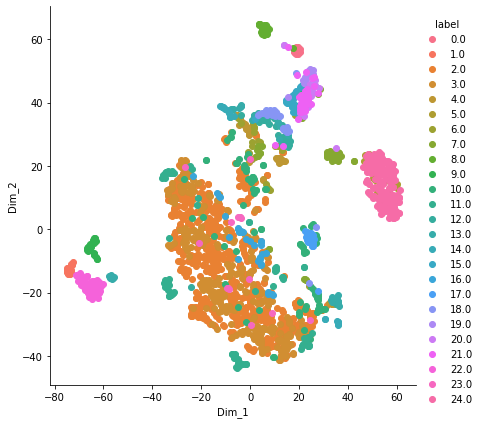

UnboundLocalError: ignored

In [24]:
epochs = 200

for epoch in range(1, epochs + 1):
        print(epoch)
        train(epoch)
        test(epoch)

        plt.plot(Epoch_Loss['train_epoch'],Epoch_Loss['train_loss'], label="train_loss")
        plt.plot(Epoch_Loss['test_epoch'],Epoch_Loss['test_loss'], label="test_loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss Score')
        plt.title('Train_Test_Loss')
        plt.legend()
        plt.savefig('./Exp03_results/plot_train_test_loss/'+str(epoch+20)+'_epoch.png', dpi=300)
        plt.show()

        with torch.no_grad():
            sample = torch.randn(64, 100).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 224, 224),
                       './Exp03_results/recon_sampling/sampling_' + str(epoch) + '.png')